British online store customer behavior and segmentation analysis.
The company mode is mainly B2B and the products are festival products.
The time range is from 2010 to 2011 and data are those transactions.
A lot of clients are vendors.

#### Attributes：

- __InvoiceNo__: number of invoice, 6 digital, started with 'c' represents canceled orders
- __StockCode__: product codes, unique 5 digital
- __Description__: name of products
- __Quantity__：numbers of products
- __InvoiceDate__：dates of invoice
- __UnitPrice__：unit price
- __CustomerID__：customer id
- __Country__：country for every customer

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#from IPython.display import display, HTML

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

## 1.Data cleaning

In [2]:
df=pd.read_csv(r'online_retail.csv')

In [3]:
df.shape

(541909, 8)

In [4]:
df.describe()
# From the describe, we try to find meaningless values, such as quantity less than 0, unitprice is 0.

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [79]:
# change data types:
df['CustomerID']=df['CustomerID'].apply(lambda x: int(x))

In [80]:
df.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
amount          0
Internal        0
week            0
weekday_name    0
day_of_week     0
interval        0
dtype: int64

In [81]:
# gives some infos on columns types and numer of null values
tab=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab=tab.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab=tab.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,week,weekday_name,day_of_week,interval
column type,object,object,object,int64,datetime64[ns],float64,int64,object,float64,object,int64,object,category,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
df[df.isna().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,week,weekday_name,day_of_week,interval


In [83]:
df=df.dropna()

In [84]:
# change data types
print('Dataframe dimensions:', df.shape)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Dataframe dimensions: (397884, 14)


In [85]:
# check the unique values
def check_value(df):
    for i in df.columns:
        count=df[i].nunique()
        print(i, ":", count)
check_value(df)

InvoiceNo : 18532
StockCode : 3665
Description : 3877
Quantity : 301
InvoiceDate : 17282
UnitPrice : 440
CustomerID : 4338
Country : 37
amount : 2939
Internal : 2
week : 6
weekday_name : 6
day_of_week : 6
interval : 360


In [86]:
#check and remove meaningless records
print('Quantity less than zero:',
      df[df.Quantity<=0].shape[0])

print('UnitPrice less than zero ',
      df[df['UnitPrice']<=0].shape[0])

print('\n% percentage: {:3.2%}'.format(df[(df.Quantity<=0)].shape[0]/df.shape[0]))

print('Customers with quantity less than zero:', 
      df.loc[(df.Quantity<=0), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Quantity less than zero: 0
UnitPrice less than zero  0

% percentage: 0.00%
Customers with quantity less than zero: []


In [87]:
print('UnitPrice:')
display(df[df.UnitPrice<=0])
print("UnitPrice but we have history:",df[(df.UnitPrice==0)].shape[0])

UnitPrice:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,week,weekday_name,day_of_week,interval


UnitPrice but we have history: 0


In [88]:
df=df[df['UnitPrice']>0]

In [89]:
df=df[df['Quantity']>0]

In [90]:
skewness = df.skew()
kurtosis = df.kurt() 

In [91]:
print(skewness,"\n",kurtosis)

InvoiceNo      -0.178524
Quantity      409.892972
UnitPrice     204.032727
CustomerID      0.025729
amount        451.443182
week            0.396272
interval        0.412034
dtype: float64 
 InvoiceNo         -1.200748
Quantity      178186.243253
UnitPrice      58140.396673
CustomerID        -1.180822
amount        232155.117219
week              -0.828926
interval          -1.110445
dtype: float64


## Countries

In [92]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [93]:
# df.groupby('Country')['CustomerID'].count().sort_values(ascending=False)
# # df.Country.value_counts(normalize=True)
country=df.groupby(['Country'])['CustomerID'].count().reset_index().sort_values('CustomerID',ascending=False)

In [94]:
country['Percentage'] = round(country['CustomerID']/sum(country['CustomerID'])*100,2)

In [95]:
# msot came from UK
country.head(10)

,Country,CustomerID,Percentage
35,United Kingdom,354321,89.05
14,Germany,9040,2.27
13,France,8341,2.10
10,EIRE,7236,1.82
30,Spain,2484,0.62
23,Netherlands,2359,0.59
3,Belgium,2031,0.51
32,Switzerland,1841,0.46
26,Portugal,1462,0.37
0,Australia,1182,0.30


In [96]:
df['amount']=df.UnitPrice*df.Quantity

In [97]:
df.sort_values('amount', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,week,weekday_name,day_of_week,interval
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.080,16446,United Kingdom,168469.600,yes,4,Friday,Friday,1.0
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.040,12346,United Kingdom,77183.600,yes,1,Tuesday,Tuesday,326.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.500,15098,United Kingdom,38970.000,yes,4,Friday,Friday,182.0
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.750,16029,United Kingdom,8142.750,yes,1,Tuesday,Tuesday,220.0
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.060,17450,United Kingdom,7144.720,yes,1,Tuesday,Tuesday,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500313,578757,16216,LETTER SHAPE PENCIL SHARPENER,1,2011-11-25 11:41:00,0.060,12748,United Kingdom,0.060,yes,4,Friday,Friday,15.0
361741,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405,United Kingdom,0.001,yes,0,Monday,Monday,74.0
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618,United Kingdom,0.001,yes,1,Tuesday,Tuesday,137.0
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952,United Kingdom,0.001,yes,4,Friday,Friday,239.0


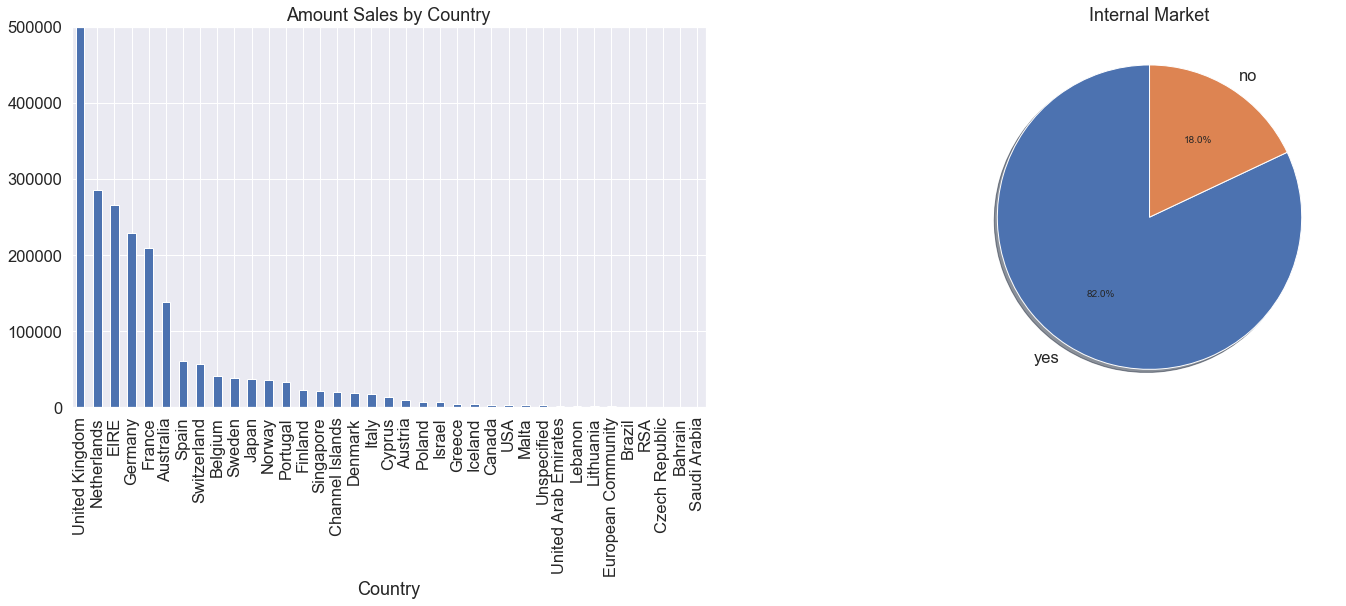

In [319]:
fig = plt.figure(figsize=(25,7))
f1 = fig.add_subplot(121)
g = df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
g.set_ylim([0,500000])
df['Internal'] = df.Country.apply(lambda x: 'yes' if x=='United Kingdom' else 'no' )
f2 = fig.add_subplot(122)
market = df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

## Transactions

In [99]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


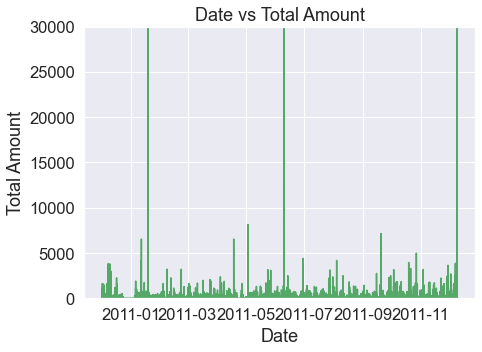

In [100]:
plt.figure(figsize=(7,5))
plt.plot(df['InvoiceDate'],df['amount'],color='g')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Date vs Total Amount')
plt.ylim(0,30000)
plt.show()

In [101]:
# decomposition
df['week']=df['InvoiceDate'].dt.weekday
df['weekday_name']=df['InvoiceDate'].dt.weekday_name

In [102]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['weekday_name'], categories=days, ordered=True)
df['day_of_week']

0         Wednesday
1         Wednesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
541904       Friday
541905       Friday
541906       Friday
541907       Friday
541908       Friday
Name: day_of_week, Length: 397884, dtype: category
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

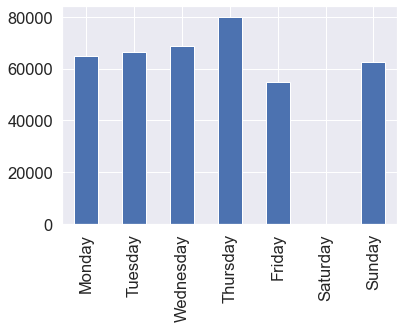

In [103]:
day = df['day_of_week'].value_counts()
day = day.sort_index()
day.plot(kind='bar')

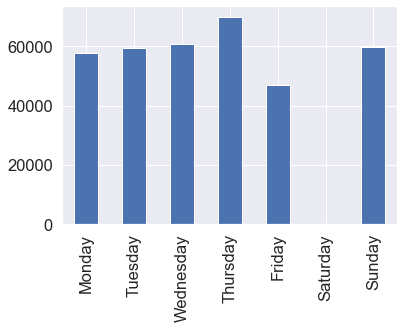

In [104]:
# Because the majority of the orders came frm UK so we only consider UK.
df_uk = df.loc[df['Country'] == 'United Kingdom']
day = df_uk['day_of_week'].value_counts()
day = day.sort_index()
day.plot(kind='bar')

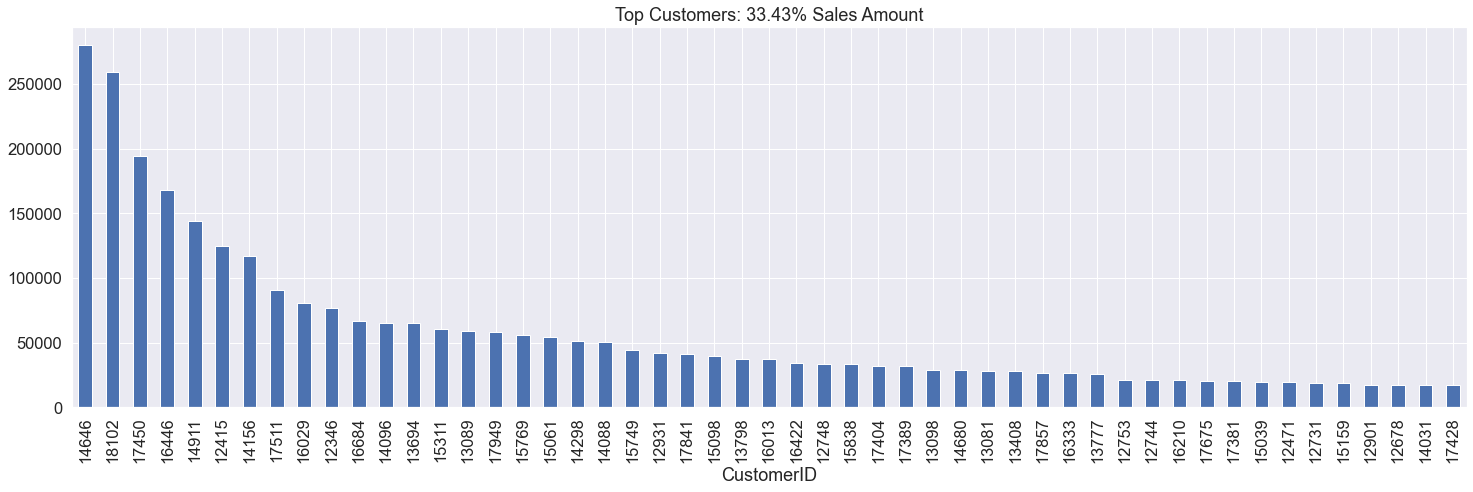

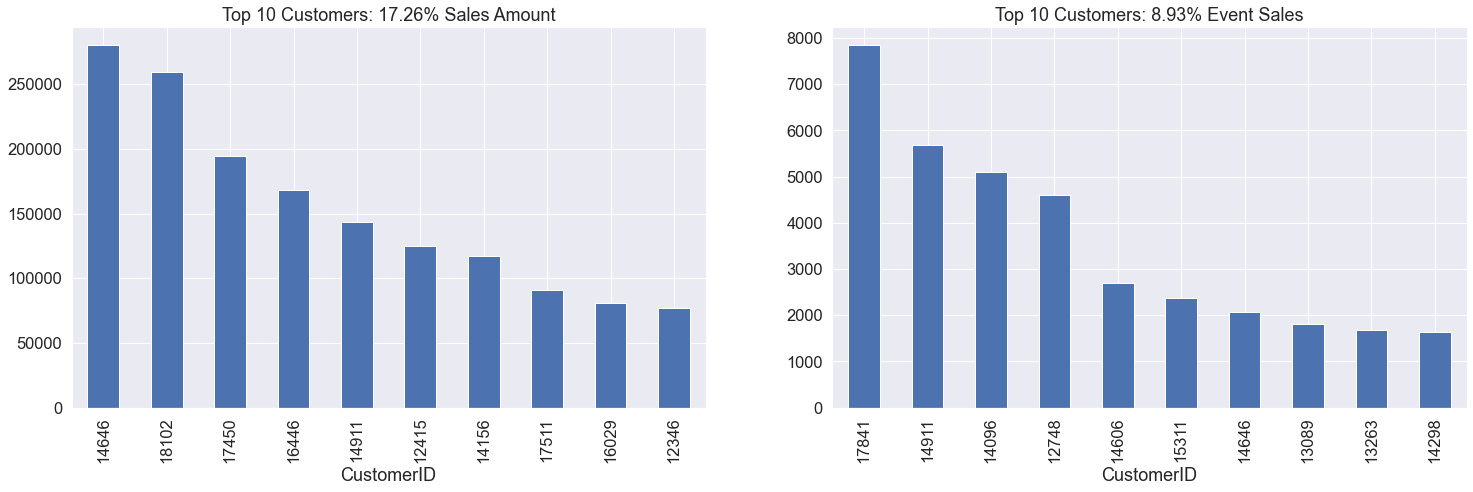

In [105]:
# the contribution of top 50, top 10 clients

fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False).iloc[:51].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)

g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False).iloc[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amount'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False).iloc[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False).iloc[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

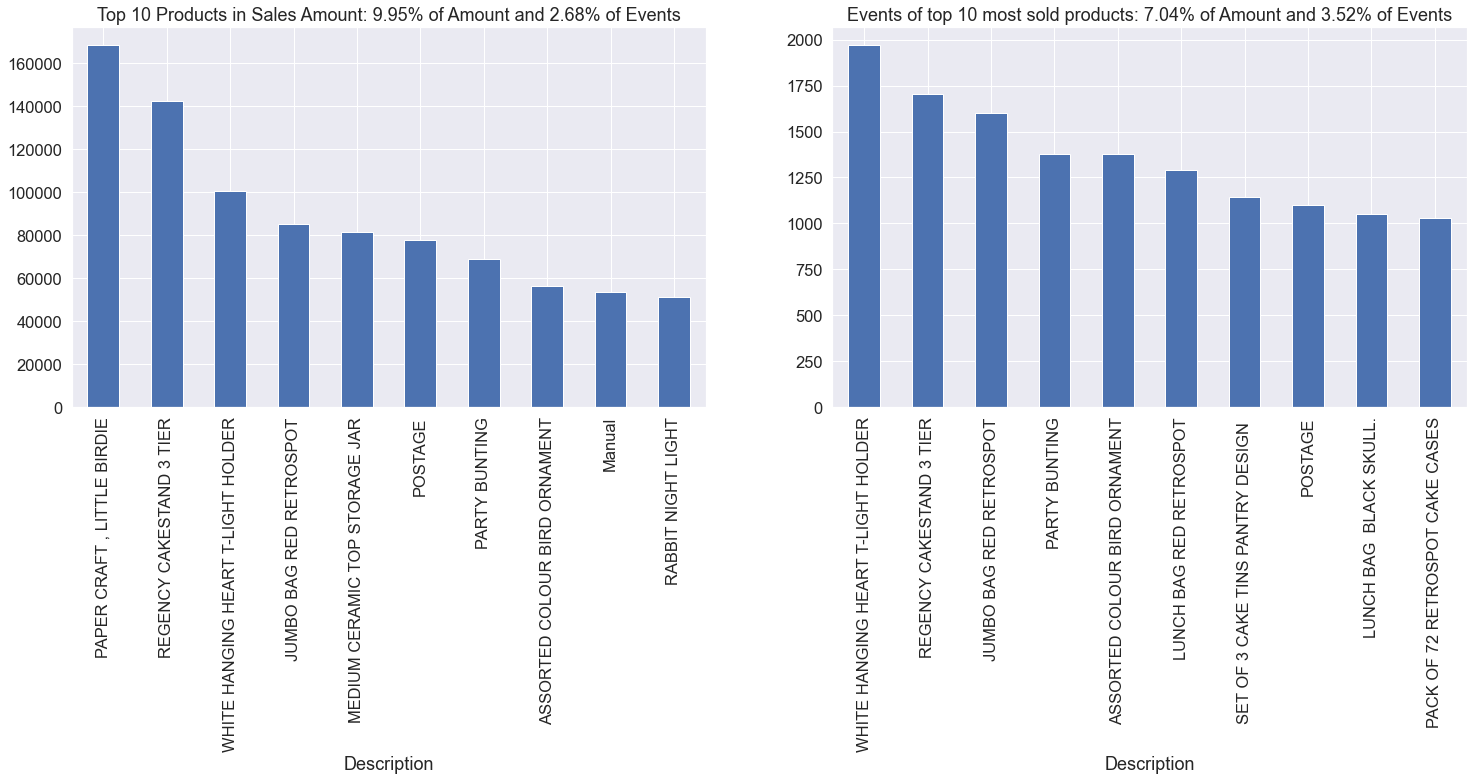

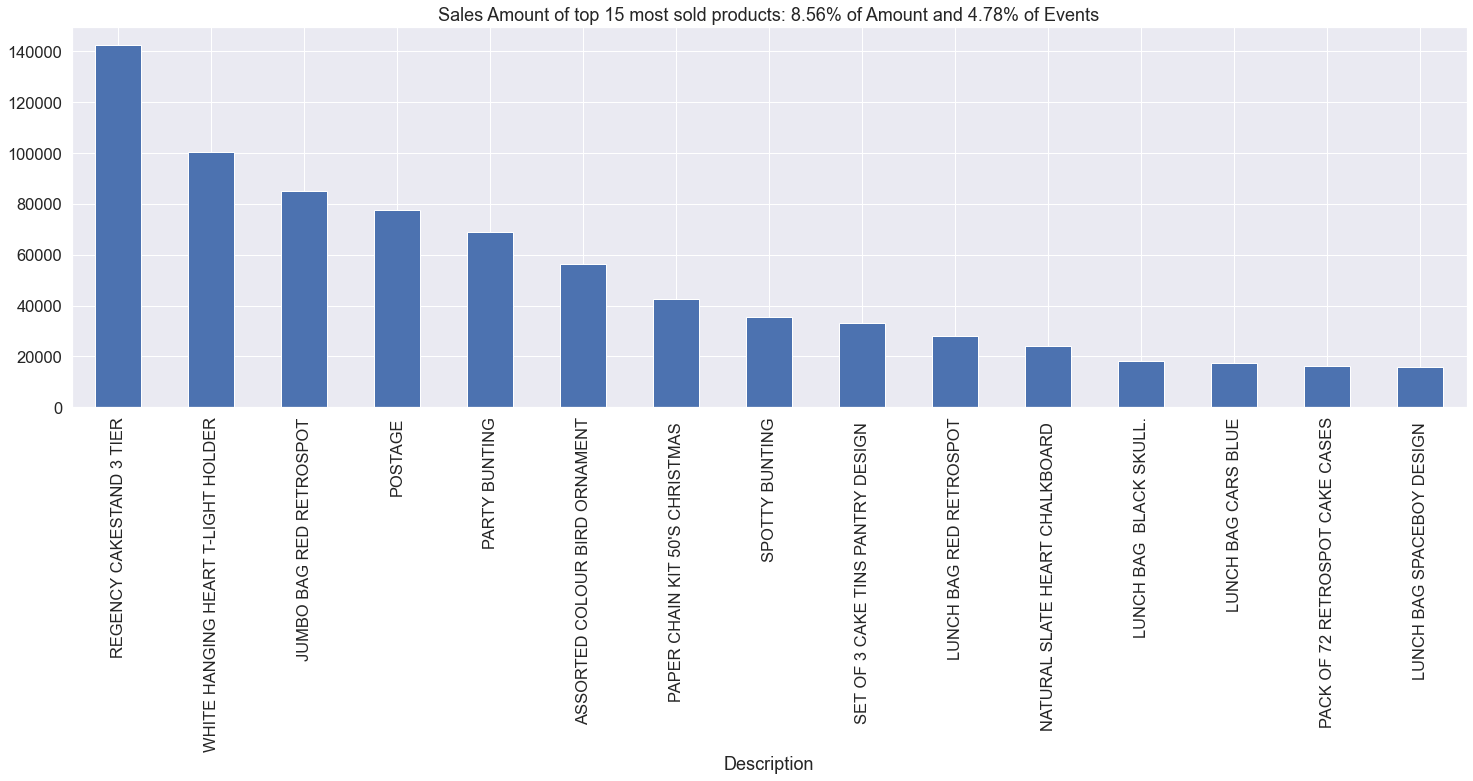

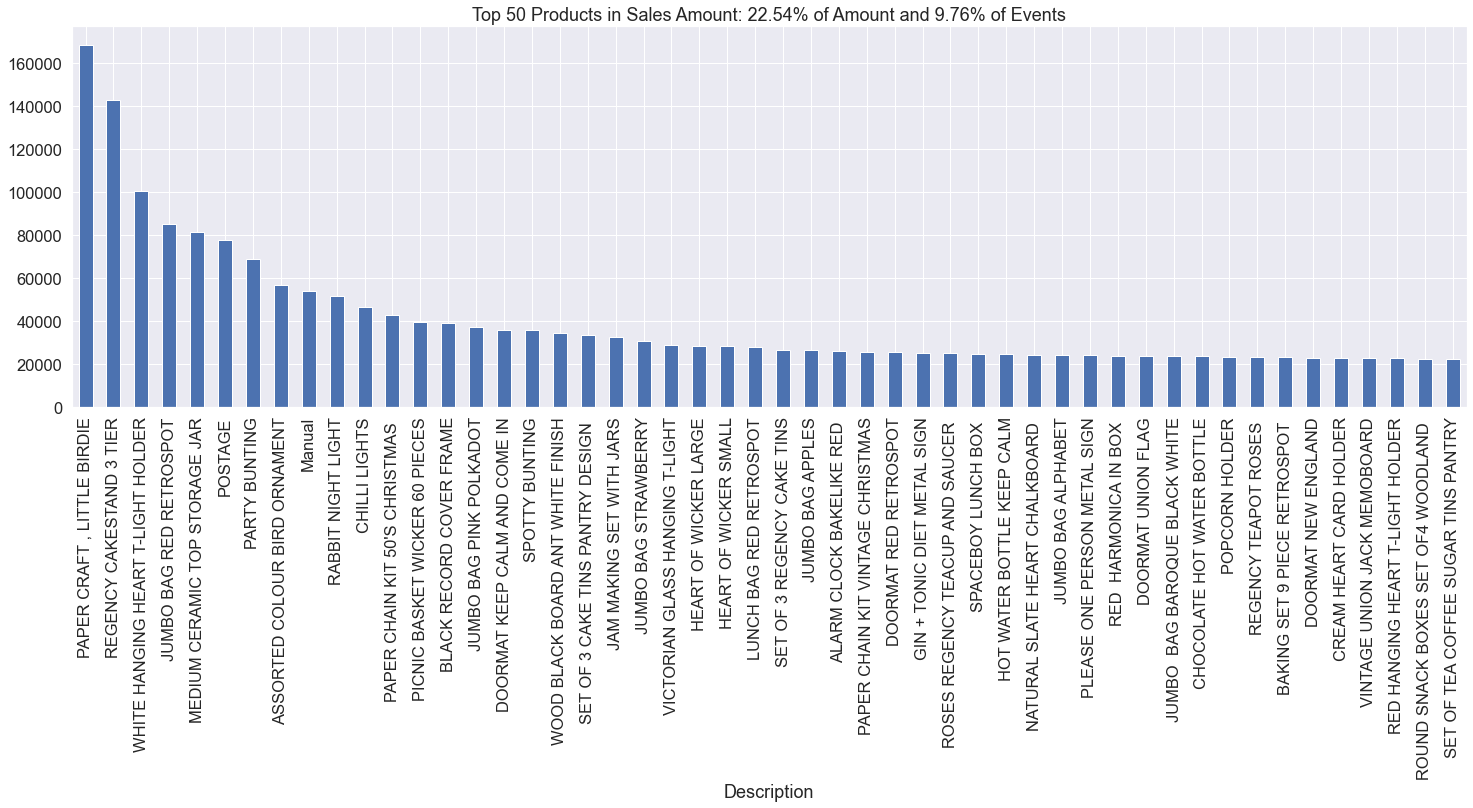

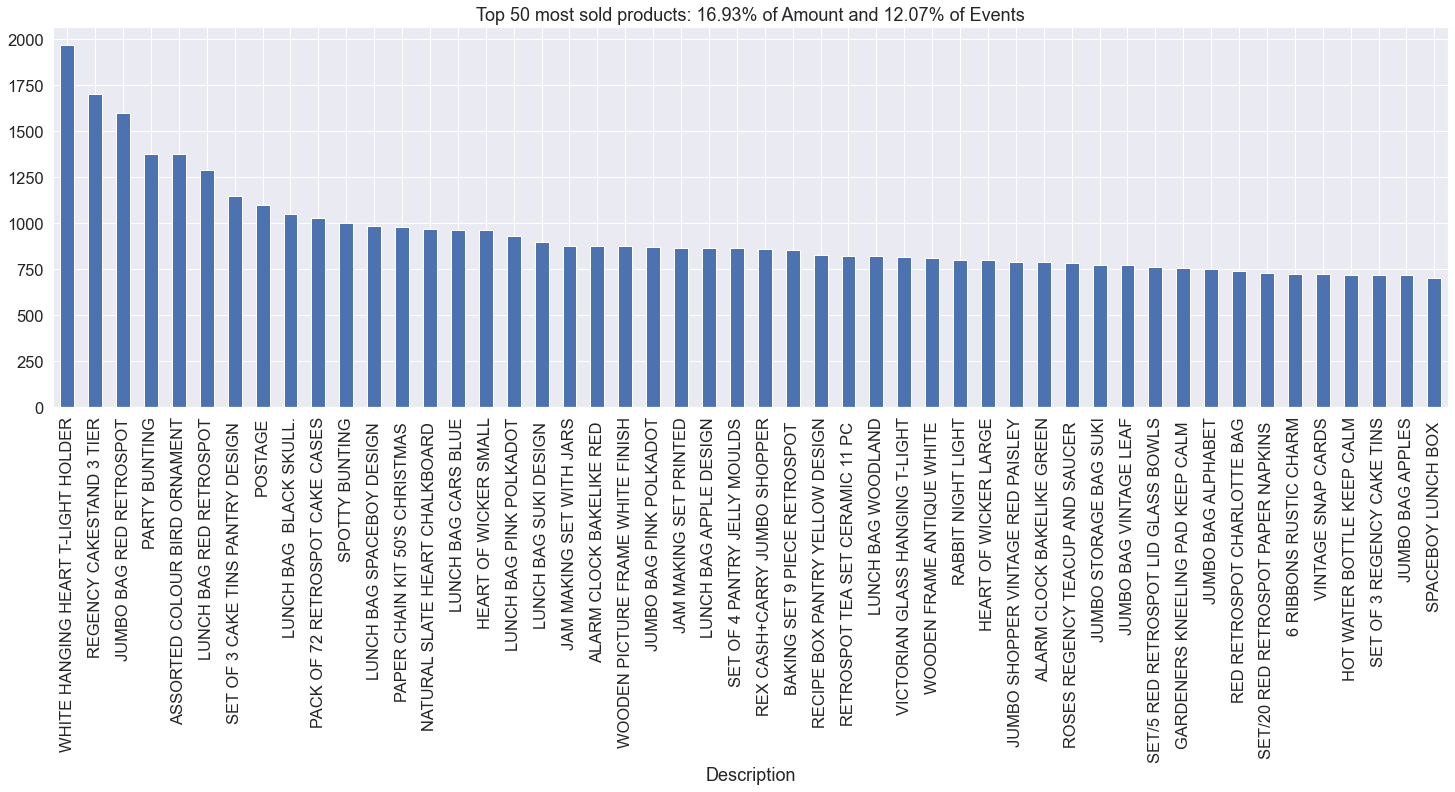

In [106]:
# top products

AmoutSum = df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

# <font color ='blue'>__Part 2：RFM Customer Segmentation__</font>

In [169]:
data= df

#### Recency

In [170]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'amount', 'Internal', 'week',
       'weekday_name', 'day_of_week', 'interval'],
      dtype='object')

In [171]:
ref=data.InvoiceDate.max()+datetime.timedelta(days=1)

In [172]:
print('Reference Date:', ref)
data['interval']=(ref-data.InvoiceDate).astype('timedelta64[D]')

Reference Date: 2011-12-10 12:50:00


In [173]:
customer_history =  data[['CustomerID', 'interval']].groupby("CustomerID").min().reset_index()

In [174]:
customer_history.rename(columns={'interval':'recency'}, inplace=True)
customer_history.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


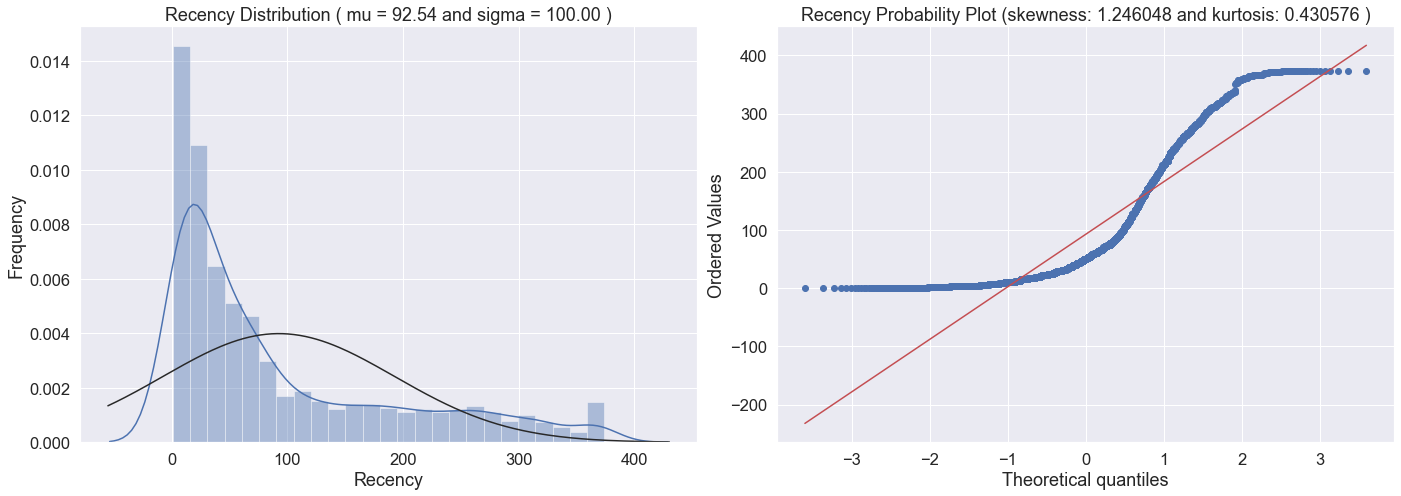

In [175]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history.recency, 'Recency')

#### Frequency

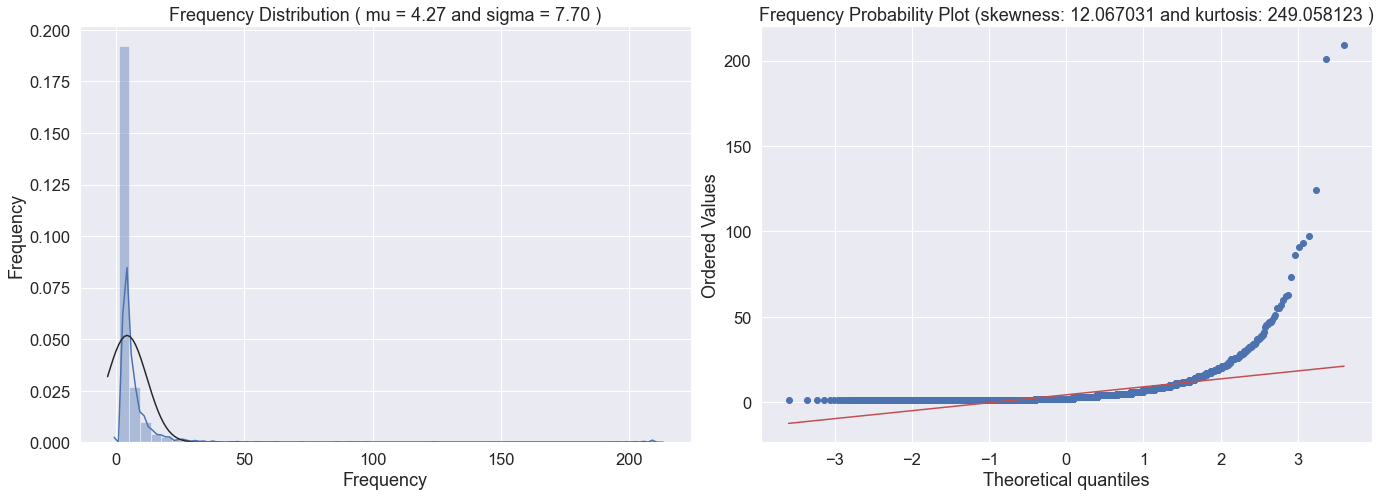

In [176]:
customer_freq = (data[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history = customer_history.merge(customer_freq)
QQ_plot(customer_history.frequency, 'Frequency')

In [177]:
customer_history.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0
frequency,4338.0,4.272015,7.697998,1.0,1.00,2.0,5.00,209.0


#### Money

In [178]:
customer_history

,CustomerID,recency,frequency
0,12346,326.0,1
1,12347,2.0,7
2,12348,75.0,4
3,12349,19.0,1
4,12350,310.0,1
...,...,...,...
4333,18280,278.0,1
4334,18281,181.0,1
4335,18282,8.0,2
4336,18283,4.0,16


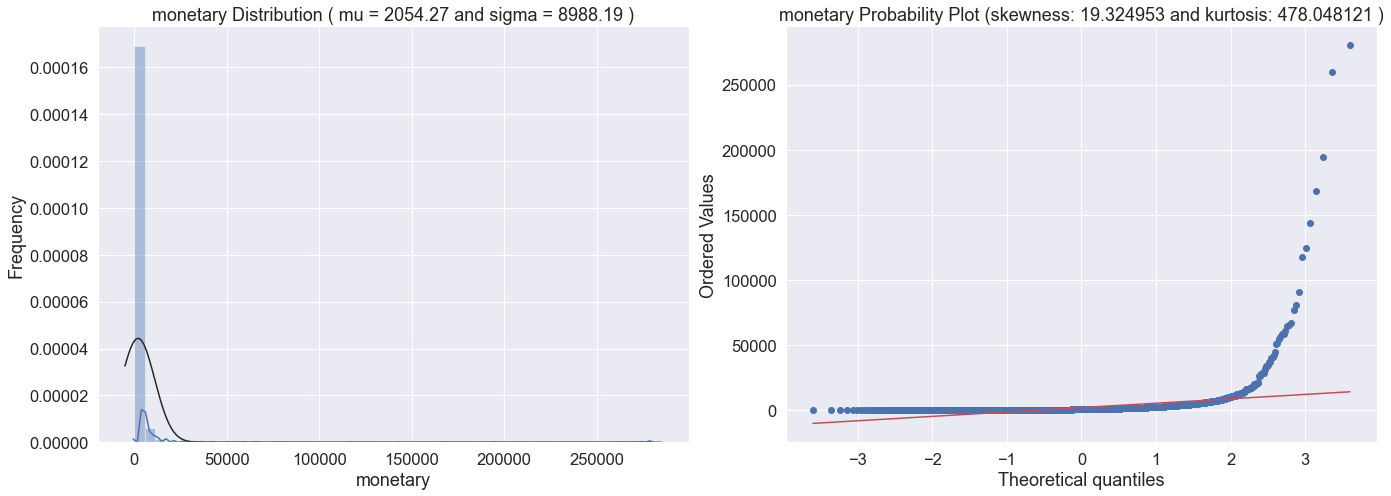

In [179]:
money=data[['CustomerID', 'amount']].groupby(['CustomerID']).sum().sort_values('amount', ascending=False).reset_index()
customer_history = customer_history.merge(money)
customer_history.rename(columns={'amount':'monetary'}, inplace=True)
QQ_plot(customer_history.monetary, 'monetary')

In [180]:
customer_history.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.00,13813.250,15299.500,16778.75,18287.00
recency,4338.0,92.536422,100.014169,1.00,18.000,51.000,142.00,374.00
frequency,4338.0,4.272015,7.697998,1.00,1.000,2.000,5.00,209.00
monetary,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02


In [181]:
customer_history.head(5)

,CustomerID,recency,frequency,monetary
0,12346,326.0,1,77183.60
1,12347,2.0,7,4310.00
2,12348,75.0,4,1797.24
3,12349,19.0,1,1757.55
4,12350,310.0,1,334.40


##### _notes_:
1. CustomerID 12346 purchased 326 days ago，only once totally，the total amount is 77183.6 dollars.
2. CustomerID 12347 purchased 2 days ago, seven times totally, the total amount is 4310 dollars

In [182]:
first_customer = data[data['CustomerID']==12346]
first_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,week,weekday_name,day_of_week,interval
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,yes,1,Tuesday,Tuesday,326.0


 We zoomed in to see the more details about 12346, we found that this customer only bought once, the quantity is huge, the unitprice is lower, the total amount is huge, then the goods are probably at clearance prices

## RFM score

In [183]:
quantiles = customer_history.quantile(q=[0.25,0.5,0.75])
# quantiles = quantiles.to_dict()

In [184]:
quantiles=quantiles.drop(columns={'CustomerID'}, axis=1)

In [185]:
quantiles.monetary=quantiles.monetary.apply(lambda x: round(x,2))

In [186]:
quantiles = quantiles.to_dict()

In [187]:
quantiles

{'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 307.41, 0.5: 674.48, 0.75: 1661.74}}

In [195]:
def RScore(x,q,ind):
    if x <= q[ind][0.25]:
        return 1
    elif x <= q[ind][0.50]:
        return 2
    elif x <= q[ind][0.75]:
        return 3
    else:
        return 4
    
def FMScore(x,q,ind):
    if x <= q[ind][0.25]:
        return 4
    elif x <= q[ind][0.50]:
        return 3
    elif x <= q[ind][0.75]:
        return 2
    else:
        return 1

In [196]:
customer_history

,CustomerID,recency,frequency,monetary,r_quartile
0,12346,326.0,1,77183.60,4
1,12347,2.0,7,4310.00,1
2,12348,75.0,4,1797.24,3
3,12349,19.0,1,1757.55,2
4,12350,310.0,1,334.40,4
...,...,...,...,...,...
4333,18280,278.0,1,180.60,4
4334,18281,181.0,1,80.82,4
4335,18282,8.0,2,178.05,1
4336,18283,4.0,16,2094.88,1


In [199]:
customer_history['r_quartile'] = customer_history['recency'].apply(RScore, args=(quantiles,'recency'))
customer_history['f_quartile'] = customer_history['frequency'].apply(FMScore, args=(quantiles,'frequency'))
customer_history['m_quartile'] = customer_history['monetary'].apply(FMScore, args=(quantiles,'monetary'))

In [200]:
customer_history

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,12346,326.0,1,77183.60,4,4,1
1,12347,2.0,7,4310.00,1,1,1
2,12348,75.0,4,1797.24,3,2,1
3,12349,19.0,1,1757.55,2,4,1
4,12350,310.0,1,334.40,4,4,3
...,...,...,...,...,...,...,...
4333,18280,278.0,1,180.60,4,4,4
4334,18281,181.0,1,80.82,4,4,4
4335,18282,8.0,2,178.05,1,3,4
4336,18283,4.0,16,2094.88,1,1,1


In [201]:
# R F M
#RFM score = r*100+f*10+m, 111 为rfm score的最高分
customer_history['RFMScore'] = customer_history.r_quartile.map(str) \
                              + customer_history.f_quartile.map(str) \
                              + customer_history.m_quartile.map(str)

customer_history.head(5)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,326.0,1,77183.60,4,4,1,441
1,12347,2.0,7,4310.00,1,1,1,111
2,12348,75.0,4,1797.24,3,2,1,321
3,12349,19.0,1,1757.55,2,4,1,241
4,12350,310.0,1,334.40,4,4,3,443


In [204]:
customer_history.sort_values('RFMScore', ascending=False).head(5)

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
1392,14237,373.0,1,161.00,4,4,4,444
3407,16990,219.0,1,179.00,4,4,4,444
419,12881,276.0,1,298.00,4,4,4,444
2232,15388,270.0,1,140.54,4,4,4,444
986,13678,152.0,1,232.60,4,4,4,444


In [205]:
print(customer_history['RFMScore'].value_counts().count())
print(customer_history['RFMScore'].max())
print(customer_history['RFMScore'].min())

61
444
111



We can score all groups and make different strategies:
    1. For the most value clients, which are not that sensitive, we can promote loyalty program and new products.
    2. For 122-223, those clients are losing, so we can send email to them or promote our products via other channels
    3. For 223-333, need to be activited again, we can send discounts to them.
    4. we don't need to pay too much attention on.
This grouping methond is not the best, we can still group them more specially.

In [206]:
customer_history['RFMScore'] = customer_history['RFMScore'].astype(int)

def rfm_level(RFMScore):
    if (RFMScore >= 0 and RFMScore < 122):
        return '1'
    elif (RFMScore >= 122 and RFMScore < 223):
        return '2'
    elif (RFMScore >= 223 and RFMScore < 333):
        return '3'
    return '4'

customer_history['RFMScore_level'] =customer_history['RFMScore'].apply(rfm_level).astype(str)

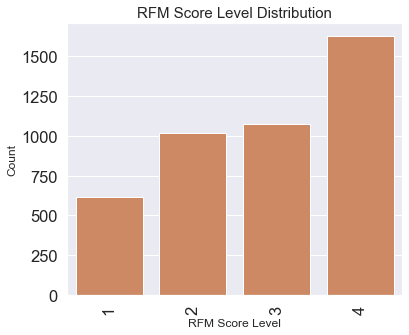

In [209]:
# RFM distribution
import seaborn as sns
color = sns.color_palette()

plt.figure(figsize=(6,5))
sns.countplot(x='RFMScore_level',data=customer_history, color = color[1])
plt.ylabel('Count',fontsize=12)
plt.xlabel('RFM Score Level', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('RFM Score Level Distribution',fontsize=15)
plt.show()

# Part 3: based on statistic model to do classification

### K-means clustering

In [211]:
ch=customer_history

In [212]:
ch.describe()

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460,2.486169,2.679806,2.500000,277.914938
std,1721.808492,100.014169,7.697998,8989.230441,1.126296,1.143825,1.118369,119.659225
min,12346.000000,1.000000,1.000000,3.750000,1.000000,1.000000,1.000000,111.000000
25%,13813.250000,18.000000,1.000000,307.415000,1.000000,2.000000,1.250000,144.000000
50%,15299.500000,51.000000,2.000000,674.485000,2.000000,3.000000,2.500000,244.000000
75%,16778.750000,142.000000,5.000000,1661.740000,3.000000,4.000000,3.750000,344.000000
max,18287.000000,374.000000,209.000000,280206.020000,4.000000,4.000000,4.000000,444.000000


In [280]:
#normalization
from sklearn.preprocessing import StandardScaler
ch['recency_log']=ch['recency'].apply(math.log)
ch['frequency_log']=ch['frequency'].apply(math.log)
ch['monetary_log']=ch['monetary'].apply(math.log)
a=ch[['recency_log', 'frequency_log', 'monetary_log']]
scaler_new=StandardScaler()

In [282]:
scaler=scaler_new.fit_transform(a)
pd.DataFrame(scaler, columns=['recency_log', 'frequency_log', 'monetary_log'])

,recency_log,frequency_log,monetary_log
0,1.409894,-1.048610,3.698719
1,-2.146498,1.111836,1.410201
2,0.383971,0.490522,0.716419
3,-0.574674,-1.048610,0.698706
4,1.374758,-1.048610,-0.617446
...,...,...,...
4333,1.298690,-1.048610,-1.106086
4334,0.999081,-1.048610,-1.743850
4335,-1.178605,-0.279044,-1.117365
4336,-1.662552,2.029655,0.837969


### K-means++
1. Placce the initial centroids far away from each other via the k-means++ algorithm, which leads to beter and more consistent results than the classic k-means
2. To user K-emans++ with scikit-learn's KMeans object, we just need to set the init paramter to k-menas++

The elbow method:
    Using the elbow method to find the optimal number of clusters. The idea behind the elbow will choose different clusters and caculate the loss, if the loss decrease slowly then we can say we found the best clusters.
    to identify the value of k where the distortion begins to increase most rapidly.
if k increase, the distortion will decrease.
because the samples will be closer to the centroids they are assigned to.
This method looks at the percentage of variance explained as a function of the number of clsters
Most precisely, if one plots the percentage of variance explained 
by theclusters against the number of clusters, the first clusters will add much infos 
(explain a lot of variance), but at some point the marginal gain will drop. 
giving an angle in the graph. The number of clusters is chosen at this point, 
hence the "elbow criterion". This 'elbow' cannot always be unambiguously identified.
Percentage of variance explained is the ratio of the between-grop variance to the total variance, also known as an F-test,
A slight variation of this method lots the curvature of the within group variance.

In [230]:
model=KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=101)

In [232]:
model=model.fit(scaler) 
labels=model.labels_
interia=model.inertia_

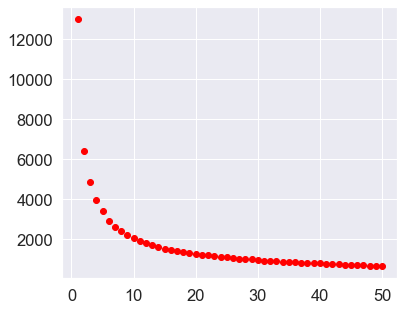

In [320]:
cl=50
corte=0.1
anterior=10000000
cost=[]
K_best=cl
for k in range(1, cl+1):
    model=KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=101)
    model=model.fit(scaler) 
    labels=model.labels_
    ineria=model.inertia_
    if (K_best ==cl) and (((anterior - ineria)/anterior)< corte): 
        K_best=k-1
    cost.append(ineria)
    anterior=ineria
plt.figure(figsize=(6,5))
plt.scatter(range(1, cl+1), cost, c='red')
plt.show()

In [245]:
K_best

7

In [252]:
scaler[:,2]

array([ 3.69871931,  1.410201  ,  0.71641884, ..., -1.11736527,
        0.83796882,  0.73389579])

In [253]:
labels

array([0, 2, 0, ..., 3, 2, 0])

The best k suggest: 7


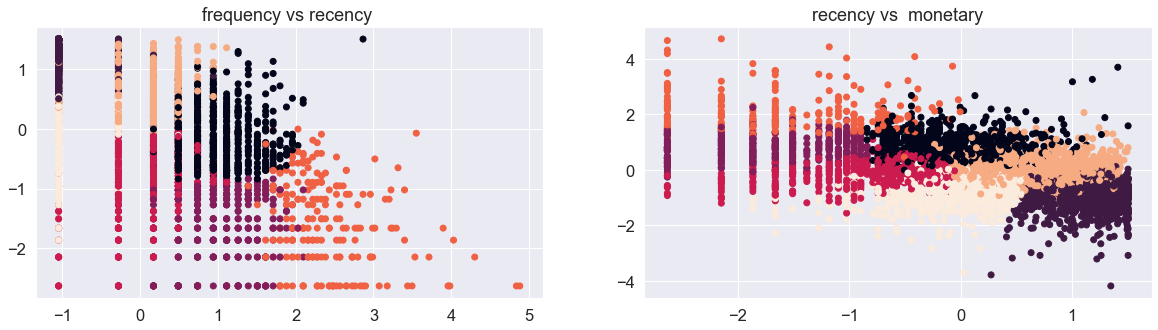

In [259]:
print('The best k suggest:', K_best)
model=KMeans(n_clusters=K_best, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=101)
model=model.fit(scaler)
labels=model.labels_

#visualization:
fig=plt.figure(figsize=(20, 5))
ax=fig.add_subplot(121)
plt.scatter(x=scaler[:,1],y=scaler[:,0],c=model.labels_.astype(float))
ax.set_title('frequency vs recency ')
ax1=fig.add_subplot(122)
ax1.set_title('recency vs  monetary')
plt.scatter(x=scaler[:, 0], y=scaler[:, 2], c=model.labels_.astype(float))

Text(0.5, 0, 'recency')

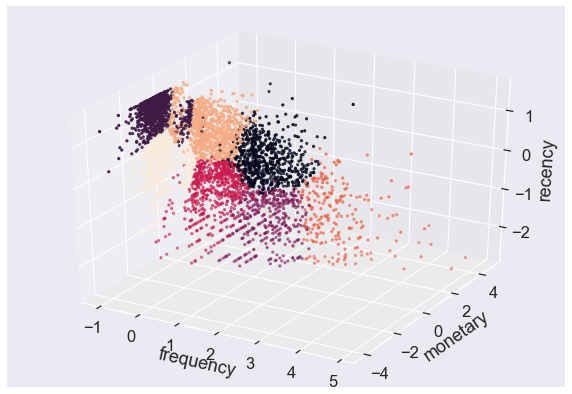

In [266]:
# 3d
fig=plt.figure(figsize=(10, 7))
ax=fig.add_subplot(111, projection='3d')
xs=scaler[:,1]
ys=scaler[:,2]
zs=scaler[:,0]
ax.scatter(xs, ys, zs, s=5, c=model.labels_.astype(float))
ax.set_xlabel('frequency')
ax.set_ylabel('monetary')
ax.set_zlabel('recency')

#### silhouette analysis on K-Means clustering

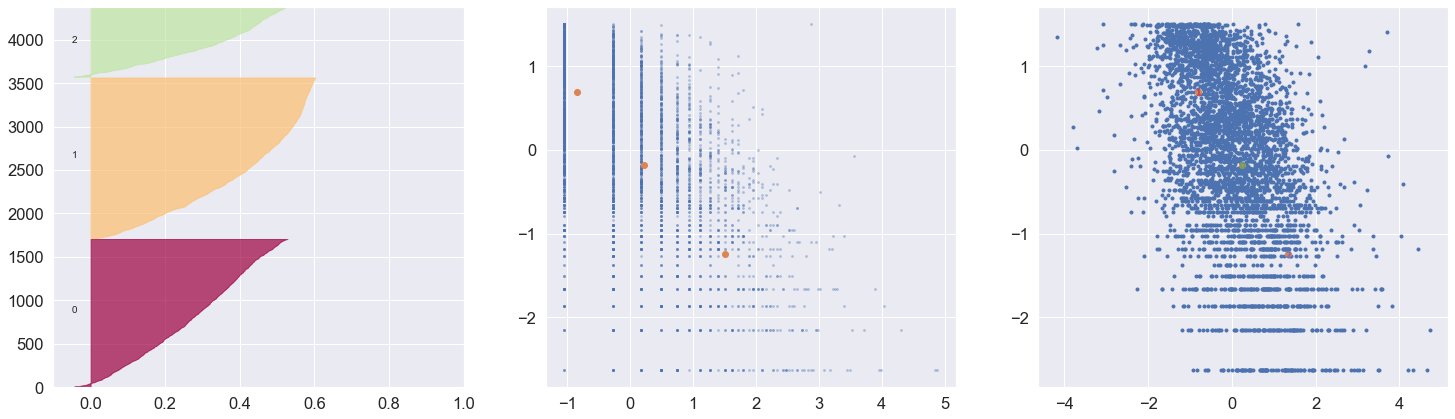

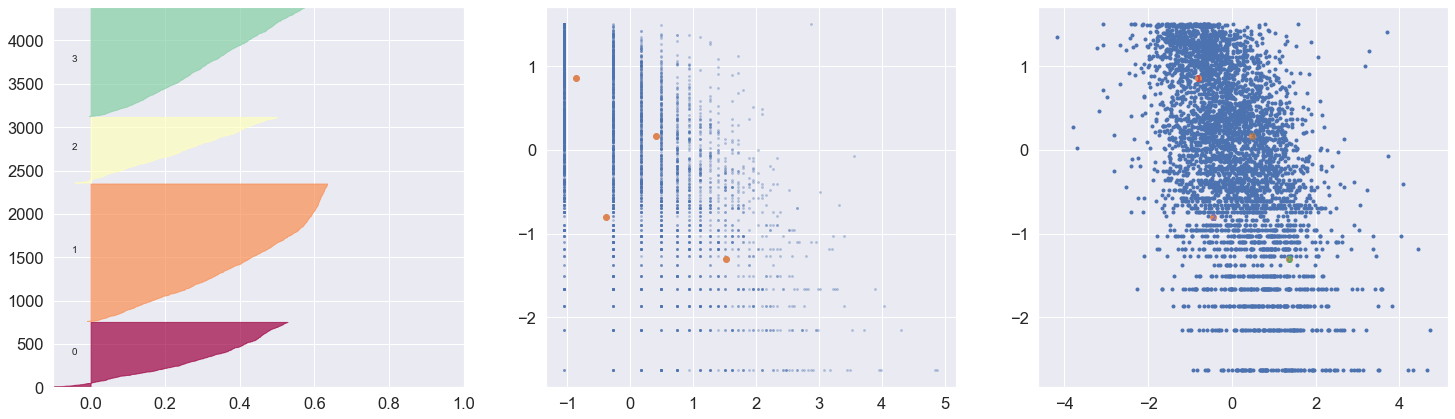

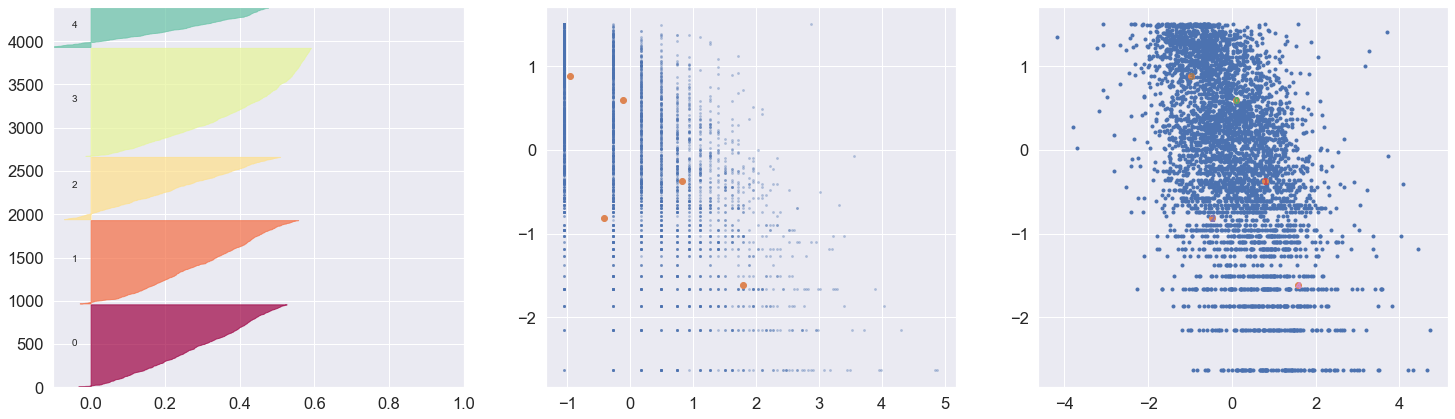

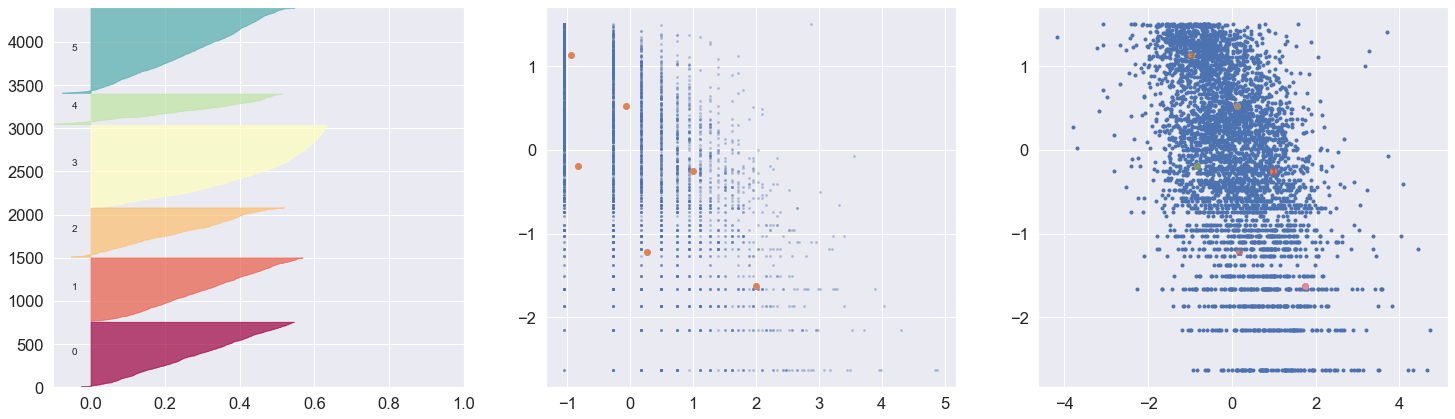

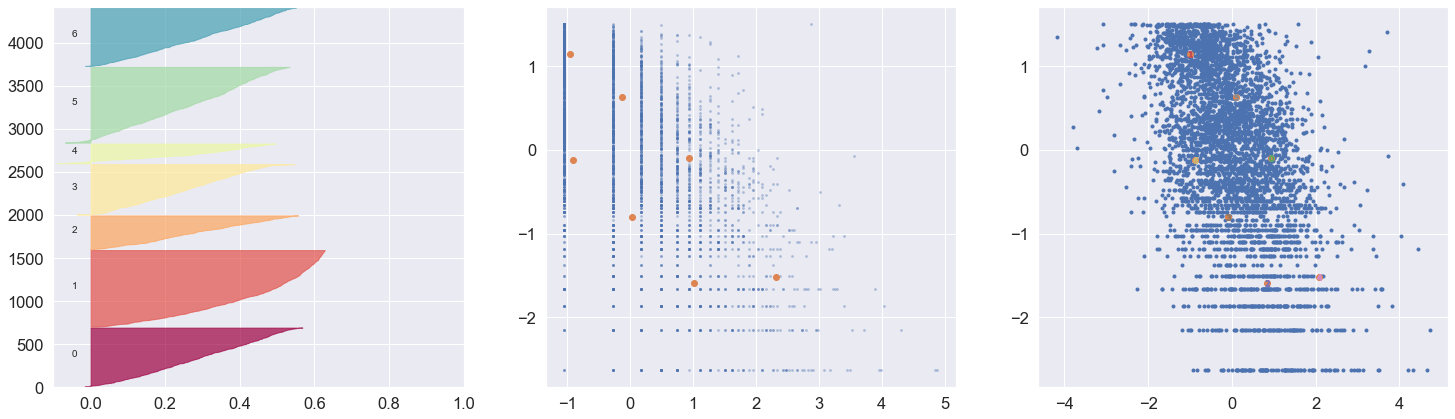

In [323]:
cluster_centers=dict()
for n_clusters in range(3, K_best+1):
    fig, (ax1, ax2, ax3)=plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(scaler)+(n_clusters+1)*10])    
    clusterer=KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=101)
    cluster_labels=clusterer.fit_predict(scaler)    
    silhouette_avg=silhouette_score(X=scaler, labels=cluster_labels)
    cluster_centers.update({n_clusters:{'cluster_center': clusterer.cluster_centers_,
                                       'silhouette_score':silhouette_avg,
                                       'labels': cluster_labels}})
    sample_silhouette_values=silhouette_samples(X=scaler, labels=cluster_labels) 
    y_lower=10
    for i in range (n_clusters):
        ith_cluster_silhouette_values=sample_silhouette_values[cluster_labels==i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        color=cm.Spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
    
        ax1.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower=y_upper+10
    centers=clusterer.cluster_centers_
    y=0
    x=1
    ax2.scatter(scaler[:,x], scaler[:,y], marker='.', s=30, lw=0, alpha=0.4, edgecolor='k')
    ax2.scatter(centers[:,x], centers[:,y], marker='o')
    x=2
    ax3.scatter(scaler[:,x], scaler[:,y], marker='.')
    ax3.scatter(centers[:,x],centers[:,y], marker='o')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker="$%d$" % i)
        

## silhouette analysis results:
because of the distribution of all records, we cannot distinguish really well.
Because according to the sales data and customers to 
differentiate, we cannot find the perfect boundary, so the bondouary for ecery variables and clustering are ambious
blurry

In [284]:
features=['recency', 'frequency', 'monetary']
for i in range(3, 8):
    print('for {} clusters the silhouette score is {:1.2f}'.format(i, cluster_centers[i]['silhouette_score']))
    print('Centers of each cluster:')
    cent_transformed =scaler_new.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed), columns=features))
    print("-"*50)


for 3 clusters the silhouette score is 0.34
Centers of each cluster:
      recency  frequency     monetary
0   33.707301   3.140933  1000.871792
1  116.940645   1.191399   262.333158
2    7.338342  10.008682  3957.580861
--------------------------------------------------
for 4 clusters the silhouette score is 0.34
Centers of each cluster:
      recency  frequency     monetary
0    6.658382  10.172577  4016.838269
1  148.935070   1.188416   263.921681
2   13.679035   1.816715   413.232575
3   55.187293   3.717692  1342.631909
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
      recency  frequency     monetary
0  101.844331   2.328417   830.363689
1   25.467694   5.423018  1978.490114
2   13.500638   1.764952   398.509227
3  153.160444   1.081631   211.733199
4    4.301300  12.965088  5275.772041
--------------------------------------------------
for 6 clusters the silhouette score is 0.31
Centers of each cluster:
 

In [290]:
customer_history['c3']=cluster_centers[3]['labels']
customer_history['c4']=cluster_centers[4]['labels']
customer_history['c5']=cluster_centers[5]['labels']
customer_history['c6']=cluster_centers[6]['labels']
customer_history['c7']=cluster_centers[7]['labels']

In [291]:
customer_history

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level,recency_log,frequency_log,monetary_log,c3,c4,c5,c6,c7
0,12346,326.0,1,77183.60,4,4,1,441,4,5.786897,0.000000,11.253942,0,3,0,1,0
1,12347,2.0,7,4310.00,1,1,1,111,1,0.693147,1.945910,8.368693,2,0,4,4,2
2,12348,75.0,4,1797.24,3,2,1,321,3,4.317488,1.386294,7.494007,0,3,1,5,0
3,12349,19.0,1,1757.55,2,4,1,241,3,2.944439,0.000000,7.471676,0,2,2,2,3
4,12350,310.0,1,334.40,4,4,3,443,4,5.736572,0.000000,5.812338,1,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18280,278.0,1,180.60,4,4,4,444,4,5.627621,0.000000,5.196285,1,1,3,3,1
4334,18281,181.0,1,80.82,4,4,4,444,4,5.198497,0.000000,4.392224,1,1,3,3,1
4335,18282,8.0,2,178.05,1,3,4,134,2,2.079442,0.693147,5.182064,0,2,2,0,3
4336,18283,4.0,16,2094.88,1,1,1,111,1,1.386294,2.772589,7.647252,2,0,4,4,2


#### Decision Tree on RFM

In [292]:
# RFM labels level
history=customer_history
X=history.iloc[:, [1,2,3]].values
y=history.iloc[:, 8]

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y)
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion='entropy', random_state=0)
clf=classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print('accuracy is ', accuracy_score(y_pred, y_test)*100)
plt.scatter(y_test ,y_pred)

In [300]:
for i in range(3, 8):
    classifier=DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    clf_fit=classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    print('accuracy', i, 'is', accuracy_score(y_pred, y_test)*100)

accuracy 3 is 93.73271889400921
accuracy 4 is 98.15668202764977
accuracy 5 is 99.81566820276497
accuracy 6 is 99.81566820276497
accuracy 7 is 99.81566820276497


##### K-Means

In [301]:
X=history.iloc[:, [1,2,3]].values
y=history.iloc[:, 14].values

accuracy is  96.86635944700461


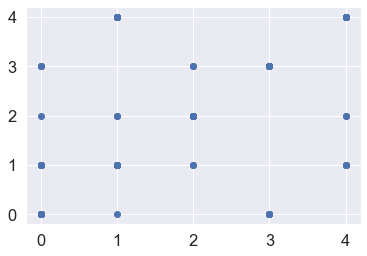

In [302]:
# K-means
X_train, X_test, y_train, y_test=train_test_split(X,y)
classifier=DecisionTreeClassifier(criterion='entropy', random_state=0)
clf=classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
print('accuracy is ', accuracy_score(y_pred, y_test)*100)
plt.scatter(y_test ,y_pred)

#### Logistic regression

In [305]:
from sklearn.linear_model import LogisticRegression

In [306]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y)

In [309]:
from sklearn.preprocessing import StandardScaler
sc_x=StandardScaler()
X_train=sc_x.fit_transform(X_train)
X_test=sc_x.fit_transform(X_test)

In [310]:
classifier=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

In [311]:
clf_fit=classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
print('accuracy', accuracy_score(y_pred, y_test)*100)

accuracy 81.84331797235022


## consider more features
such as : 
1. products category
2. international or domestic
3. amount per order
4. the recenst transaction date

cross-sale, upgrade or degrade custom behaviors and period analysis of customers

Products category need to use NLP to count word frequency of describsion then identify the category of products.